In [221]:
import pickle
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

fileList = {"freeboard":"pickles/freeboard_db.pkl", "humordata":"pickles/humordata_6047_db.pkl", "star":"pickles/star_db.pkl",
           "sisa":"pickles/sisa_db.pkl", "best":"pickles/humorbest_db.pkl", "bestofbest":"pickles/bestofbest_50000_db.pkl", "love":"pickles/love_db.pkl"}
dfs = {}
for board in fileList.keys():
    with open(fileList[board],"rb") as f :
        dfs[board] = pd.DataFrame.from_dict(pickle.load(f)).set_index('contentID')



In [222]:
for board in fileList.keys():
    print("{}: {} articles".format(board, len(dfs[board].index)))

bestofbest: 54034 articles
freeboard: 10000 articles
humordata: 6047 articles
best: 9457 articles
star: 10000 articles
love: 10000 articles
sisa: 10000 articles


In [223]:
df1 = pd.concat([df for df in dfs.values()], axis=0)
df1 = df1[df1['writerVisitingCount'].str.contains('-') == False]
#remove duplicate articles
df = df1.reset_index().drop_duplicates(subset='contentID', keep='first').set_index('contentID')

In [242]:
len(df1[df1.board =='star')

SyntaxError: invalid syntax (<ipython-input-242-e7683ace01bc>, line 1)

In [225]:
from datetime import datetime
import operator
# import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from scipy.stats.stats import pearsonr
from operator import truediv
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Index = ['contentID', 'writerName', 'writerSignInDate', 'writerVisitingCount',
       'recommendCount', 'viewCount', 'memoCount', 'postTime',
       'normalPostCount', 'bestPostCount', 'BOBPostCount', 'board', 'title',
       'changjakOption', 'permOption', 'prohibitBestOption',
       'prohibitBOBOption', 'prohibitBoninOption', 'prohibitOutsidePermOption',
       'imgCount', 'videoCount', 'youtubeCount', 'textLineCount', 'bestTime',
       'BoBTime', 'okTime', 'memoTime', 'okIn3600s', 'bad', 'good', 'rcmd',
       'memoIn3600s']

# datatype 정리
for col in ['writerVisitingCount', 'viewCount', 'memoCount', 'normalPostCount', 'bestPostCount', 'BOBPostCount']:
    df[col] = pd.to_numeric(df[col]).copy()


######### 새로운 feature 추가
# 게시물 중 베오베 비율
df['BOBratio'] = df.BOBPostCount / df.normalPostCount
#  베오베 label
df['isBOB'] = df.BoBTime.apply(lambda e: True if e != 0 else False)
# 15분 이전의 추천과 댓글
df['okIn900s'] = df.okTime.apply(lambda e : len(list(filter(lambda f: f<=300, e))))
df['memoIn900s'] = df.memoTime.apply(lambda e : len(list(filter(lambda f: f<=900, e))))
# 추천수 비추천수 분리
df['bad'] = df.recommendCount.apply(lambda e: (e.split('/')[1]) if '/' in e else 0)
df['good'] = df.recommendCount.apply(lambda e: (e.split('/')[0]) if '/' in e else e)
df['rcmd'] = df.recommendCount.apply(lambda e: (e.split('/')[0]) if '/' not in e else int(e.split('/')[0]) - int(e.split('/')[1]))
# df.drop('recommendCount', axis=1,inplace=True)
# 시간대별로 나누는 과정 
df['postHour'] = df.postTime.apply(lambda e: e.split(' ')[1].split(':')[0])
df['timeZone'] = df.postHour.apply(lambda e: "morning" if int(e)>=3 and int(e)<9 else "noon" if int(e)>=9 and int(e)<15 else "evening" if int(e)>=15 and int(e)<21 else "night")
df_timeZone = pd.get_dummies(df['timeZone'])
df = pd.concat([df, df_timeZone,], axis=1,)
df = pd.concat([df, pd.get_dummies(df['board'])], axis=1)

######## 정규화 시키는 과정 scaler.fit(data).transform(data)로 정규화 
scaler = preprocessing.StandardScaler()

normalizing_cols = ['okIn900s', 'BOBratio', 'imgCount', 'youtubeCount', 'videoCount', 'writerVisitingCount', 'memoIn900s', 
                     'normalPostCount', 'bestPostCount', 'BOBPostCount', 'textLineCount',
                     'memoCount']
integerize_cols = ['isBOB', 'changjakOption', 'permOption', 'prohibitBestOption', 'prohibitBOBOption', 'prohibitBoninOption', 'prohibitOutsidePermOption']

for col in normalizing_cols:
    df[col] =  scaler.fit(df[col]).transform(df[col])
    
for col in integerize_cols:
    df[col] = df[col].apply(lambda e : 0 if e==False else 1)
    
    df = df.loc[:,~df.columns.duplicated()]

In [226]:
df.index

Index(['bestofbest_227000', 'bestofbest_227001', 'bestofbest_227003',
       'bestofbest_227004', 'bestofbest_227005', 'bestofbest_227006',
       'bestofbest_227007', 'bestofbest_227008', 'bestofbest_227009',
       'bestofbest_227010',
       ...
       'humordata_1655193', 'humordata_1655594', 'humordata_1661670',
       'humordata_1585617', 'humordata_1610186', 'humordata_1657168',
       'humordata_1620251', 'humordata_1549535', 'humordata_1570594',
       'humordata_1491651'],
      dtype='object', name='contentID', length=98565)

In [227]:
df.to_pickle('df_test.pkl')

In [228]:
from scipy.stats.stats import spearmanr

memo_r = {}
ok_r = {}
for board in ['love','sisa','humordata','freeboard','star']:
    rec = df[df.board==board].recommendCount.values
    ok_l = []
    memo_l = []
    for time in [60, 300, 600, 900, 1200, 1500, 3600]:
        okln =  df[df.board == board].okTime.apply(lambda e : len(list(filter(lambda f: f<=time, e))))
        memoln = df[df.board == board].memoTime.apply(lambda e : len(list(filter(lambda f: f<=time, e))))
        memo_l.append (spearmanr(memoln, rec)[0])
        ok_l.append ( spearmanr(okln, rec)[0] )
    memo_r[board] = memo_l
    ok_r[board] = ok_l

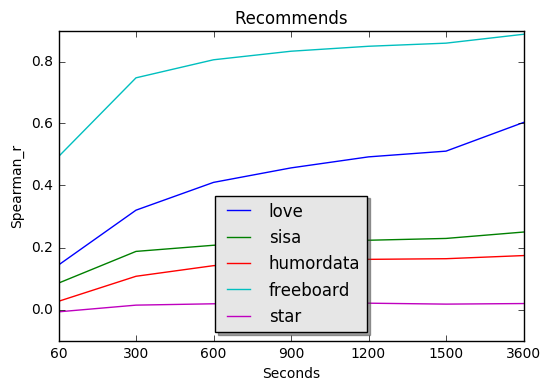

In [229]:
import matplotlib.pyplot as plt
%matplotlib inline  

x = [0,1,2,3,4,5,6]
f, (ax) = plt.subplots(nrows=1, ncols=1)
for board in ['love','sisa','humordata','freeboard','star']:
    ax.plot(x, ok_r[board], label=board)
ax.set_xticklabels( [60, 300, 600, 900, 1200, 1500, 3600])
ax.set_xlabel('Seconds')
ax.set_ylabel('Spearman_r')
ax.set_title('Recommends')
# Now add the legend with some customizations.
legend = ax.legend(loc='lower center', shadow=True)

# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')



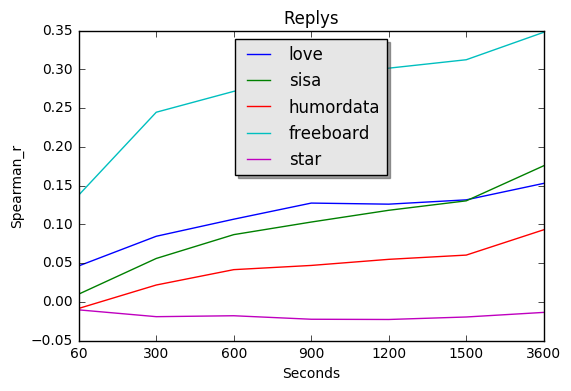

In [230]:
import matplotlib.pyplot as plt
%matplotlib inline  

x = [0,1,2,3,4,5,6]
f, (ax) = plt.subplots(nrows=1, ncols=1)
for board in ['love','sisa','humordata','freeboard','star']:
    ax.plot(x, memo_r[board], label=board)
ax.set_xticklabels( [60, 300, 600, 900, 1200, 1500, 3600])
ax.set_xlabel('Seconds')
ax.set_ylabel('Spearman_r')
ax.set_title('Replys')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper center', shadow=True)

# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')

In [231]:
f.savefig('memo_time.png', bbox_inches='tight')

In [232]:
img_count = {}
for board in ['love','sisa','humordata','freeboard','star']:
    rec = df[df.board==board].recommendCount.values
    img_count[board] = spearmanr(rec, df[df.board ==board].imgCount.values)[0]
    

In [233]:
img_count

{'freeboard': 0.16047196147534784,
 'humordata': 0.1236463442882838,
 'love': 0.13880852866388879,
 'sisa': 0.12381995971066082,
 'star': 0.071511471798757428}

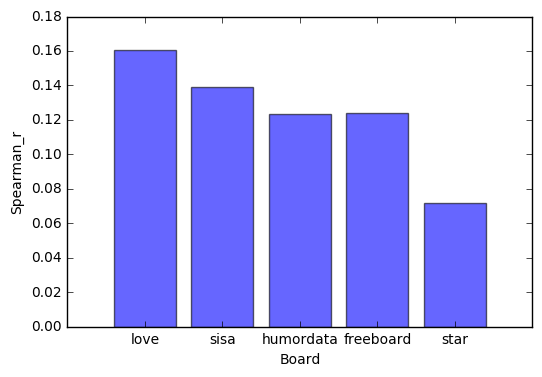

In [234]:
position = np.arange(0, 5)
# (['love','sisa','humordata','freeboard','star']
bar = plt.bar(position, list(img_count.values()), align='center', alpha=0.6)
plt.xticks(position,['love','sisa','humordata','freeboard','star'])
plt.ylabel("Spearman_r")
plt.xlabel("Board")
plt.alpha = 0.3
plt.show()

In [235]:
list(img_count.values())

[0.16047196147534784,
 0.13880852866388879,
 0.1236463442882838,
 0.12381995971066082,
 0.071511471798757428]

array([706, 451, 401, ...,  15,   4,   2])

In [248]:
spearmanr(df.viewCount.values, df.good.values.astype('float'))

SpearmanrResult(correlation=0.85517681065474127, pvalue=0.0)

In [243]:
df.iloc[55]

writerName                                                               시바s리갈
writerSignInDate                                                    2012-01-25
writerVisitingCount                                                   0.463031
recommendCount                                                             421
viewCount                                                                73041
memoCount                                                             0.787374
postTime                                                   2016/01/05 18:13:57
normalPostCount                                                      -0.111036
bestPostCount                                                        -0.218149
BOBPostCount                                                         -0.187198
board                                                                humordata
title                                                       번식기에 접어든 자라들의 구애활동
changjakOption                                      

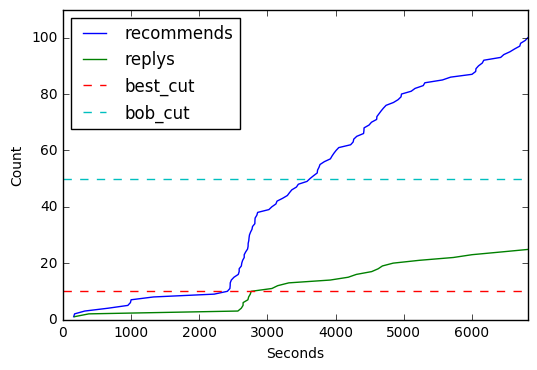

In [244]:
sample = df.iloc[55]
plt.plot(sample.okTime, np.arange(1,len(sample.okTime)+1), label = 'recommends')
plt.plot(sample.memoTime, np.arange(1,len(sample.memoTime)+1), label = 'replys')
plt.plot(np.linspace(0,sample.okTime[99],num=100), np.ones((100,1)) * 10, linestyle='--',label = 'best_cut')
plt.plot(np.linspace(0,sample.okTime[99],num=100), np.ones((100,1)) * 50, linestyle='--', label='bob_cut')

plt.xlim(0,sample.okTime[99])
plt.ylim(0,110)
plt.legend(loc="left upper")

plt.ylabel('Count')
plt.xlabel('Seconds')
plt.savefig('oks_vs_time.png', bbox_inches='tight')
# plt.show()

In [215]:
plt.show()